# 1. Difficulty-Based Clustering of Queries


In [29]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [30]:
file_path = 'processed_dataset.csv'
data = pd.read_csv(file_path)

In [31]:
if all(col in data.columns for col in ['difficulty', 'sql_length', 'question_length']):
    data['sql_length_norm'] = data['sql_length'] / data['sql_length'].max()
    data['question_length_norm'] = data['question_length'] / data['question_length'].max()

    if not pd.api.types.is_numeric_dtype(data['difficulty']):
        data['difficulty_encoded'] = data['difficulty'].astype('category').cat.codes
else:
    raise ValueError("The dataset does not contain the required columns for clustering.")

In [32]:
data.head()

,question_id,db_id,question,evidence,SQL,difficulty,sql_length,difficulty_encoded,question_length,question_length_norm,sql_length_norm
0,0,california_schools,what is the highest eligible free rate for k-1...,eligible free rate for k-12 = `free meal count...,SELECT `Free Meal Count (K-12)` / `Enrollment ...,simple,180,2,16,0.32,0.124481
1,1,california_schools,please list the lowest three eligible free rat...,eligible free rates for students aged 5-17 = `...,SELECT `Free Meal Count (Ages 5-17)` / `Enroll...,moderate,280,1,15,0.30,0.193638
2,2,california_schools,please list the zip code of all the charter sc...,charter schools refers to `charter school (y/n...,SELECT T2.Zip FROM frpm AS T1 INNER JOIN schoo...,simple,178,2,16,0.32,0.123098
3,3,california_schools,what is the unabbreviated mailing street addre...,NaN,SELECT T2.MailStreet FROM frpm AS T1 INNER JOI...,simple,133,2,18,0.36,0.091978
4,4,california_schools,please list the phone numbers of the direct ch...,charter schools refers to `charter school (y/n...,SELECT T2.Phone FROM frpm AS T1 INNER JOIN sch...,moderate,200,1,15,0.30,0.138313


In [33]:
features = ['difficulty_encoded', 'sql_length_norm', 'question_length_norm']
X = data[features]
X.head()

,difficulty_encoded,sql_length_norm,question_length_norm
0,2,0.124481,0.32
1,1,0.193638,0.30
2,2,0.123098,0.32
3,2,0.091978,0.36
4,1,0.138313,0.30


In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.74224104,  0.21037811,  0.258981  ],
       [-0.76685115,  1.34850016,  0.07990212],
       [ 0.74224104,  0.18761567,  0.258981  ],
       ...,
       [-0.76685115,  1.30297528,  1.8706909 ],
       [ 0.74224104,  0.02827858,  0.43805988],
       [-0.76685115,  0.29004666,  1.69161202]])

In [35]:
clustering_algorithms = {
    "K-Means": KMeans(n_clusters=3, random_state=42),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "Gaussian Mixture": GaussianMixture(n_components=3, random_state=42)
}

results = {}


Running K-Means...


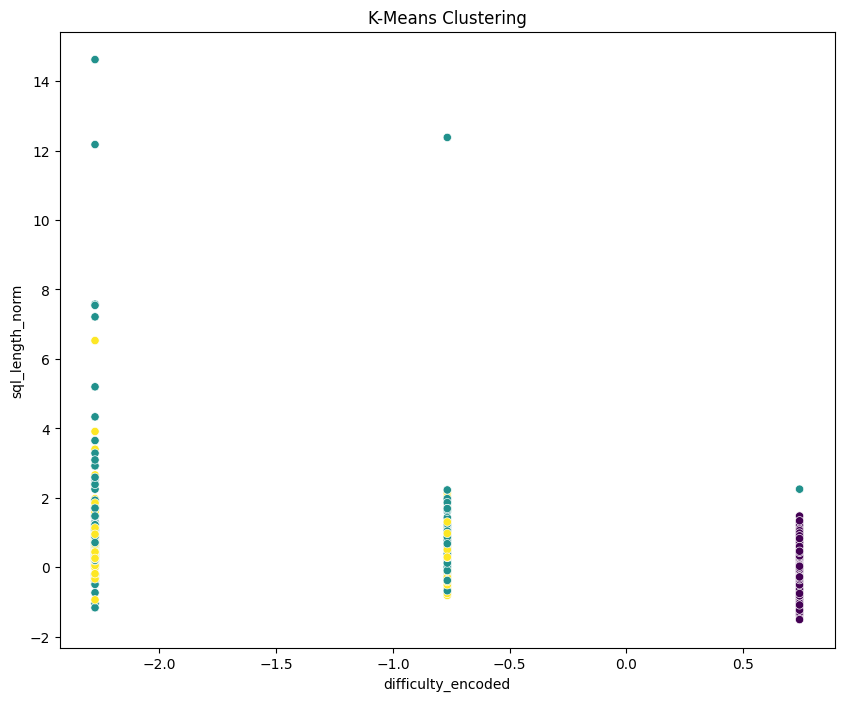

Running DBSCAN...


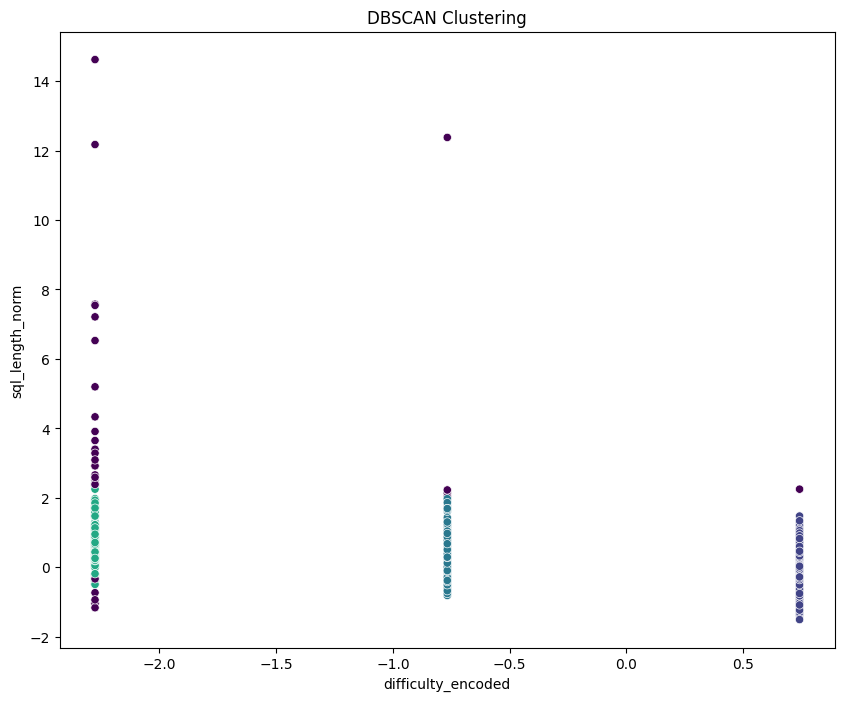

Running Gaussian Mixture...


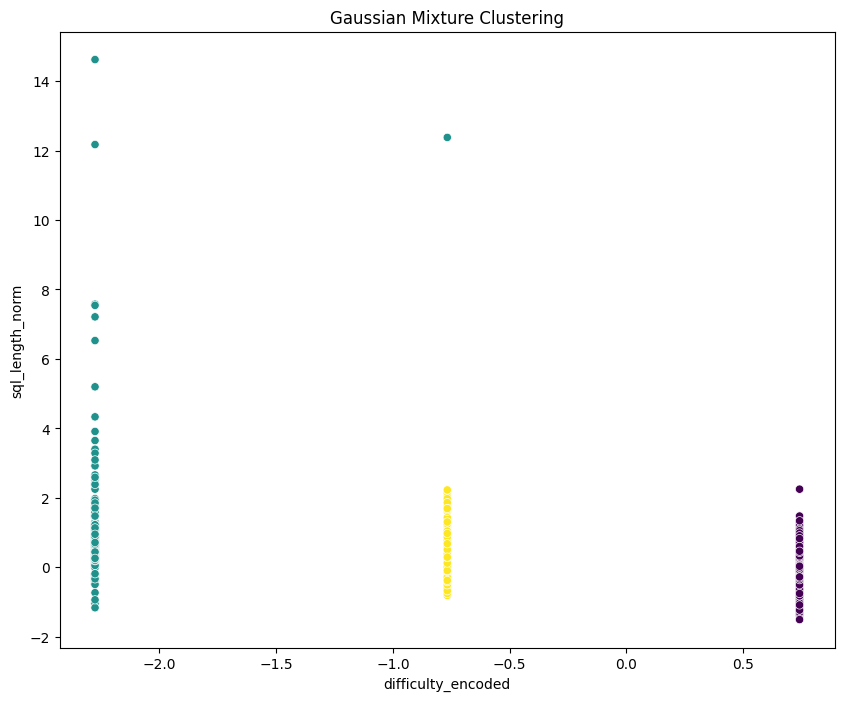

In [36]:
for name, algorithm in clustering_algorithms.items():
    print(f"Running {name}...")
    
    if name == "Gaussian Mixture":
        labels = algorithm.fit_predict(X_scaled)
    else:
        algorithm.fit(X_scaled)
        labels = algorithm.labels_
    
    if len(set(labels)) > 1: 
        silhouette = silhouette_score(X_scaled, labels)
        dbi = davies_bouldin_score(X_scaled, labels)
        chi = calinski_harabasz_score(X_scaled, labels)
    else:
        silhouette = -1
        dbi = float('inf')
        chi = -1

    results[name] = {
        "Labels": labels,
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": dbi,
        "Calinski-Harabasz Index": chi
    }
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, palette='viridis', legend=None)
    plt.title(f"{name} Clustering")
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.show()


In [37]:
comparison_df = pd.DataFrame({
    "Algorithm": list(results.keys()),
    "Silhouette Score": [results[algo]["Silhouette Score"] for algo in results],
    "Davies-Bouldin Index": [results[algo]["Davies-Bouldin Index"] for algo in results],
    "Calinski-Harabasz Index": [results[algo]["Calinski-Harabasz Index"] for algo in results]
})

In [38]:
print("Clustering Comparison:")
print(comparison_df)


Clustering Comparison:
          Algorithm  Silhouette Score  Davies-Bouldin Index  \
0           K-Means          0.439557              1.156015   
1            DBSCAN          0.396091              1.329488   
2  Gaussian Mixture          0.416143              1.324833   

   Calinski-Harabasz Index  
0               786.926561  
1               359.621598  
2               724.253976  


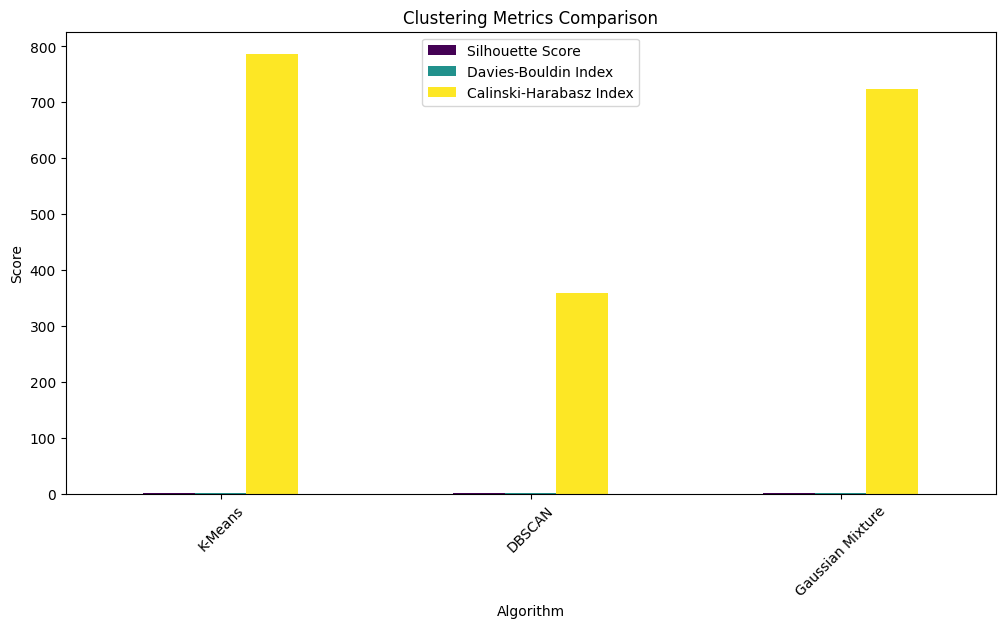

In [39]:
comparison_df.set_index("Algorithm").plot(kind="bar", figsize=(12, 6), colormap="viridis")
plt.title("Clustering Metrics Comparison")
plt.ylabel("Score")
plt.xlabel("Algorithm")
plt.xticks(rotation=45)
plt.show()

/var/folders/pr/ydlx3rfj3sq65q5pkjgnkqgh0000gn/T/ipykernel_52427/4081551092.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


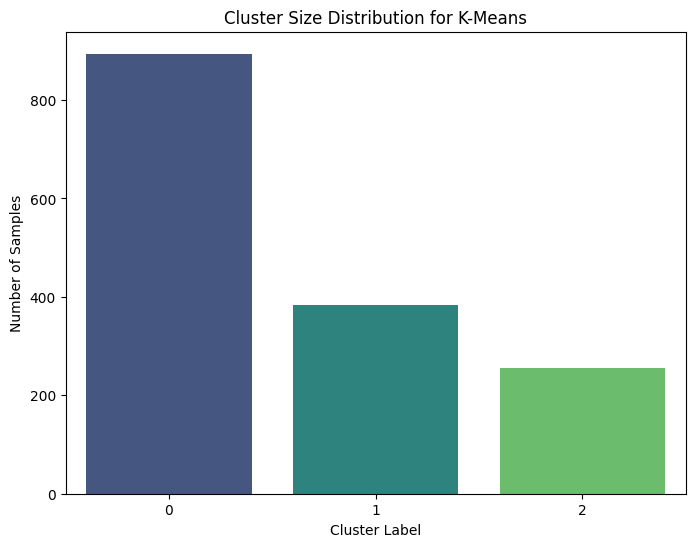

/var/folders/pr/ydlx3rfj3sq65q5pkjgnkqgh0000gn/T/ipykernel_52427/4081551092.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


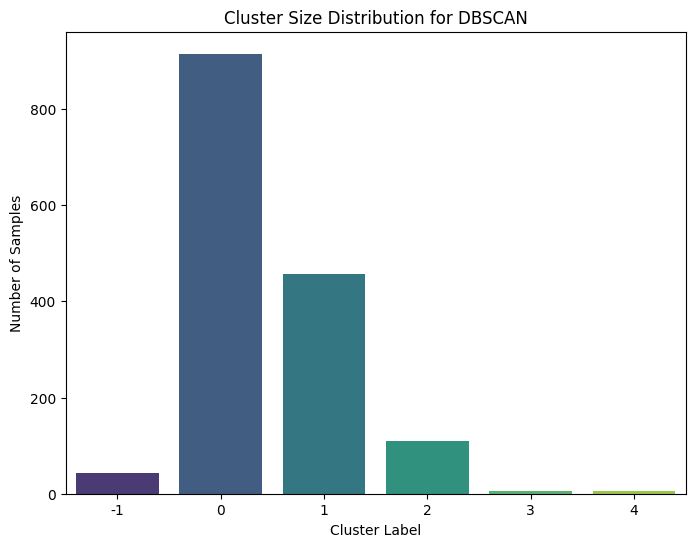

/var/folders/pr/ydlx3rfj3sq65q5pkjgnkqgh0000gn/T/ipykernel_52427/4081551092.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


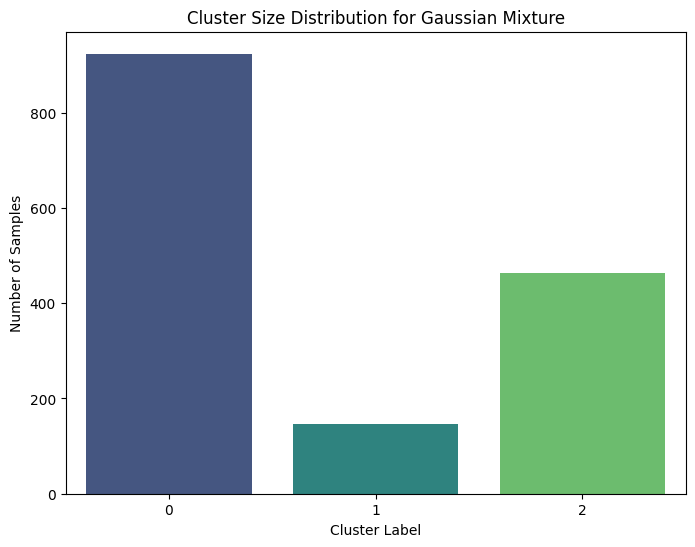

In [40]:
for name, result in results.items():
    labels = result["Labels"]
    unique, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=unique, y=counts, palette="viridis")
    plt.title(f"Cluster Size Distribution for {name}")
    plt.xlabel("Cluster Label")
    plt.ylabel("Number of Samples")
    plt.show()

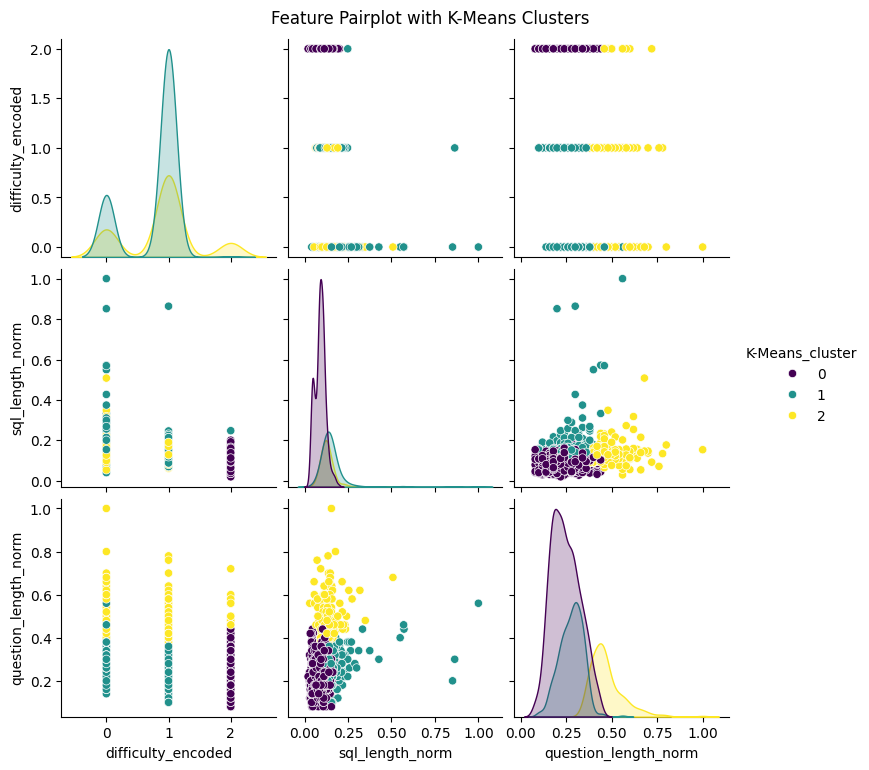

In [41]:
import seaborn as sns

# Add cluster labels to the dataset
for name, result in results.items():
    data[f"{name}_cluster"] = result["Labels"]

# Pairplot for K-Means (replace with other algorithms as needed)
sns.pairplot(data, vars=features, hue="K-Means_cluster", palette="viridis", diag_kind="kde")
plt.suptitle("Feature Pairplot with K-Means Clusters", y=1.02)
plt.show()

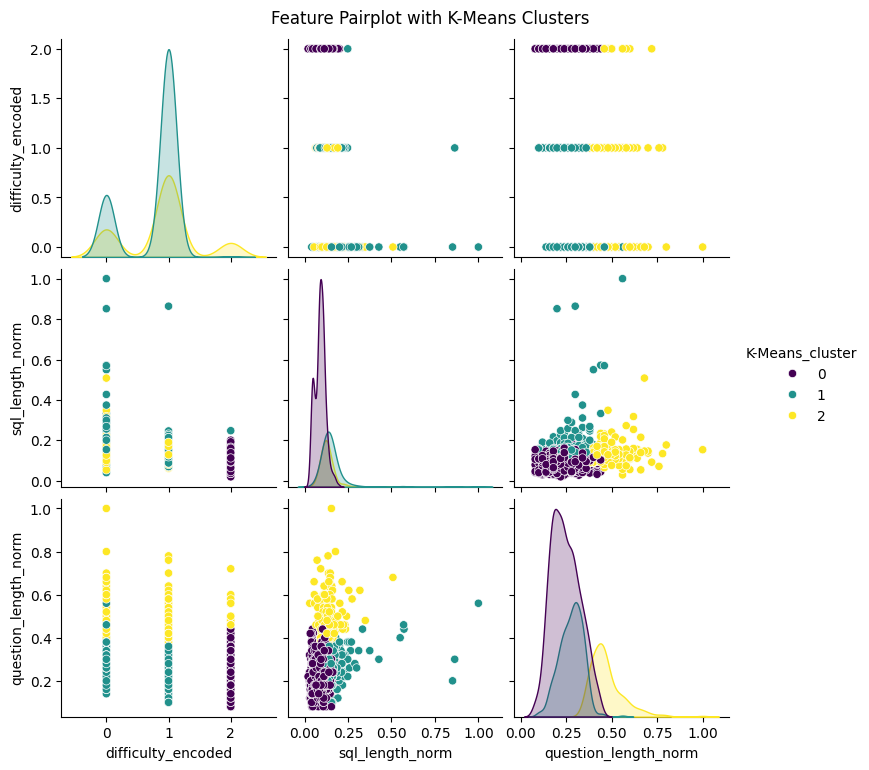

In [42]:
import seaborn as sns

# Add cluster labels to the dataset
for name, result in results.items():
    data[f"{name}_cluster"] = result["Labels"]

# Pairplot for K-Means (replace with other algorithms as needed)
sns.pairplot(data, vars=features, hue="K-Means_cluster", palette="viridis", diag_kind="kde")
plt.suptitle("Feature Pairplot with K-Means Clusters", y=1.02)
plt.show()

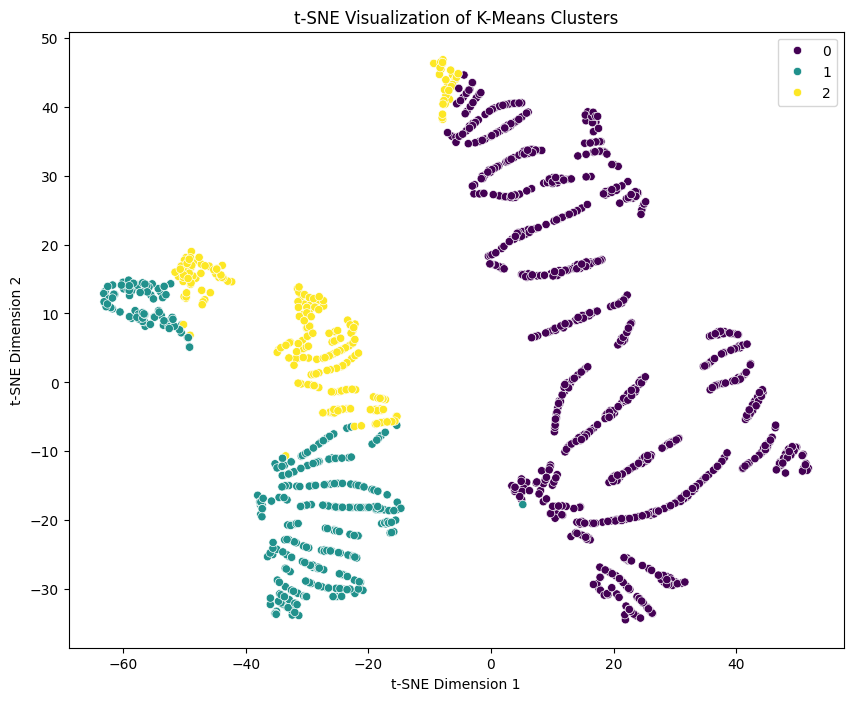

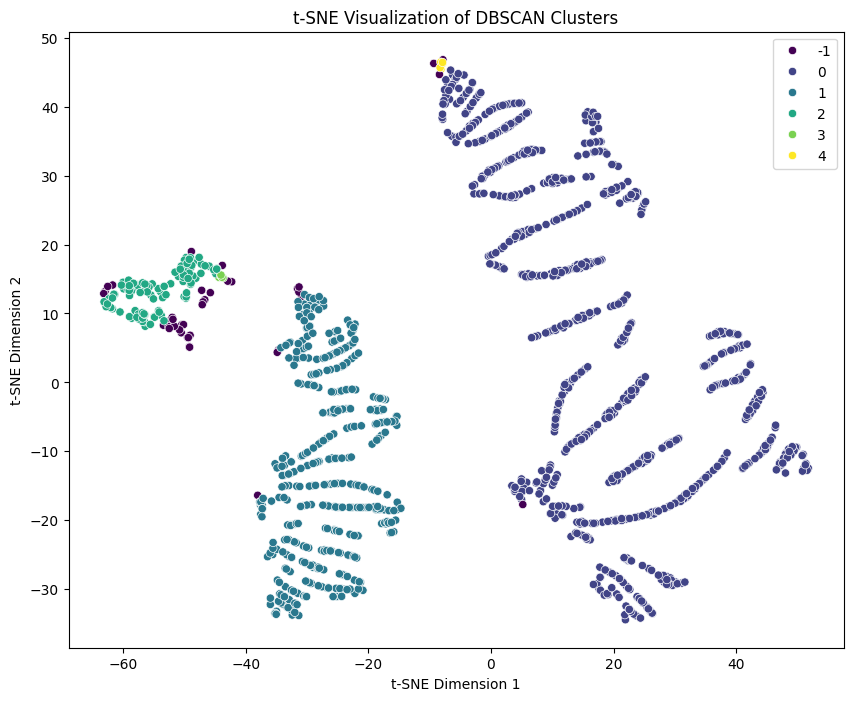

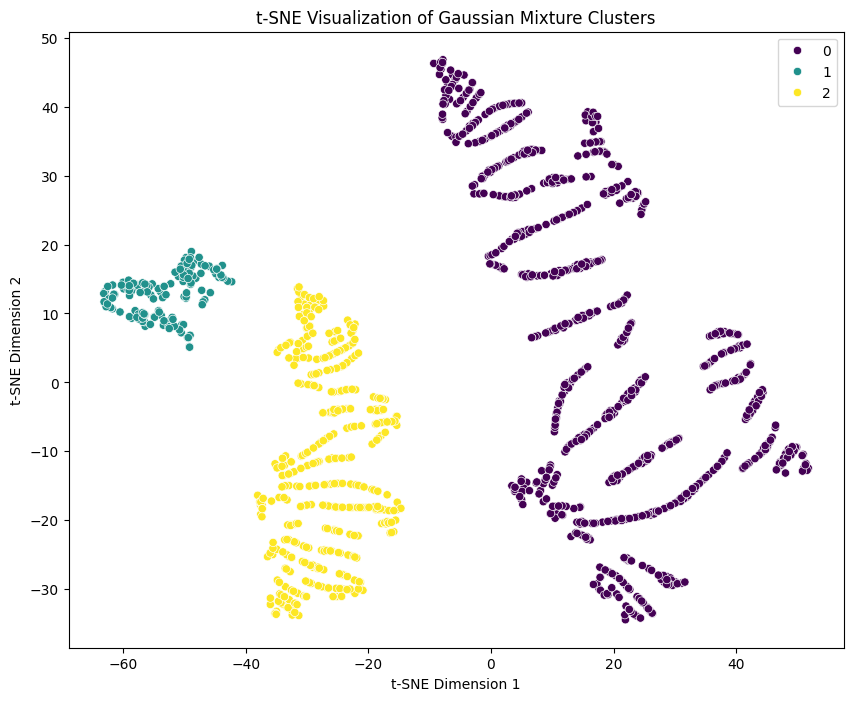

In [43]:
from sklearn.manifold import TSNE

# Reduce dimensionality for visualization
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)

# Plot clusters for each algorithm
for name, result in results.items():
    labels = result["Labels"]
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette="viridis", legend="full")
    plt.title(f"t-SNE Visualization of {name} Clusters")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

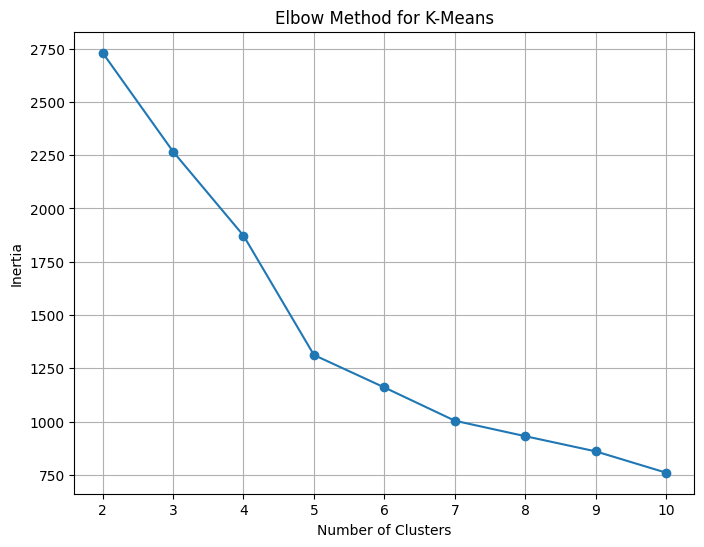

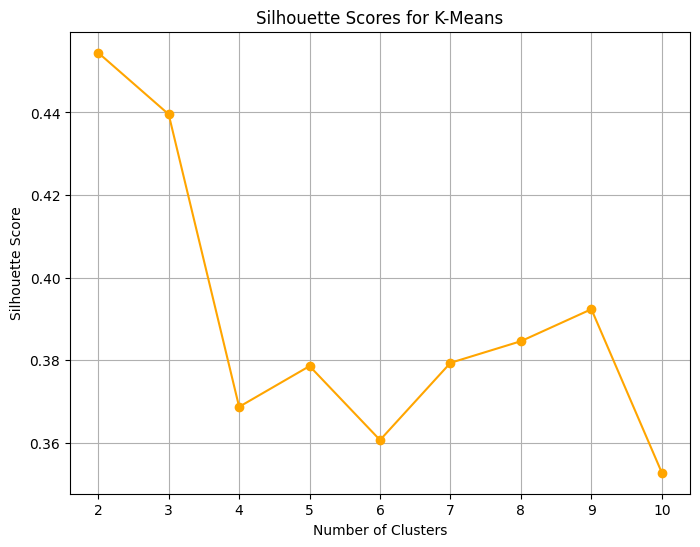

In [44]:
from sklearn.metrics import silhouette_score

# Calculate inertia and silhouette score for different numbers of clusters
inertia = []
silhouettes = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot inertia (Elbow Method)
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for K-Means")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.xticks(k_range)
plt.grid()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouettes, marker='o', color='orange')
plt.title("Silhouette Scores for K-Means")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(k_range)
plt.grid()
plt.show()